<a href="https://colab.research.google.com/github/Tanmoym047/garbage-detection/blob/main/garbage_df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Working dir
import os, pathlib, sys, random, numpy as np, tensorflow as tf
WORK_DIR = '/content/garbage_project'
os.makedirs(WORK_DIR, exist_ok=True)
%cd $WORK_DIR


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/garbage_project


In [2]:

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

# (Optional) speed opts — safe on most Colab runtimes
try:
    tf.config.optimizer.set_jit(True)   # XLA
except Exception as e:
    print("XLA not enabled:", e)
try:
    from tensorflow.keras.mixed_precision import set_global_policy
    set_global_policy("mixed_float16")  # automatic loss scaling on GPU
    print("Mixed precision enabled.")
except Exception as e:
    print("Mixed precision not enabled:", e)

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision enabled.


Total valid images: 19776  | Skipped bad/non-images: 0
Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


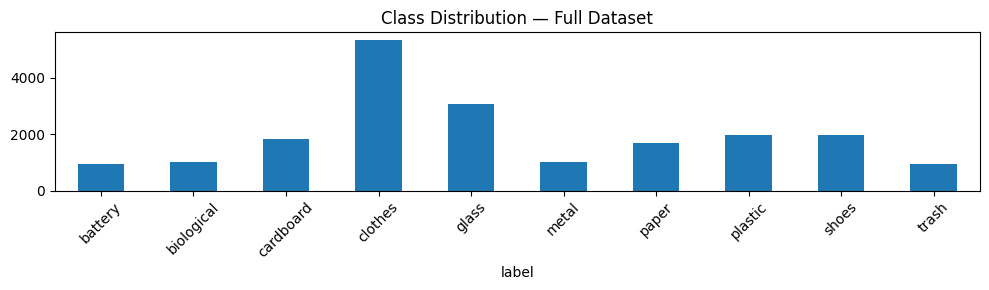

In [3]:
# =========================
# Colab cell 2: Point to dataset dir
# =========================
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# If using Kaggle: auto-discover class root
def find_class_root(base: Path, target_classes):
    targets = set(c.lower() for c in target_classes)
    for p in [base] + list(base.rglob("*")):
        if p.is_dir():
            subs = [d.name.lower() for d in p.iterdir() if d.is_dir()]
            if len(set(subs) & targets) >= 9:
                return p
    return base

TARGET_CLASSES = ["battery","biological","cardboard","clothes","glass","metal","paper","plastic","shoes","trash"]
ALLOWED_EXTS   = {".jpg",".jpeg",".png",".bmp",".webp",".jfif"}

    # 👇 change this to your Drive dataset folder if not using Kaggle
DATA_DIR = Path('/content/drive/MyDrive/garbage-dataset')


# Enumerate files, filter non-images & corrupts
all_rows, bad_files = [], []
for cls_dir in sorted([d for d in DATA_DIR.iterdir() if d.is_dir()]):
    cname = cls_dir.name.lower()
    if cname not in [c.lower() for c in TARGET_CLASSES]:
        continue
    for f in cls_dir.rglob("*"):
        if f.is_file() and f.suffix.lower() in ALLOWED_EXTS:
            try:
                with Image.open(f) as im: im.verify()
                all_rows.append({"filepath": str(f), "label": cls_dir.name})
            except (UnidentifiedImageError, OSError, ValueError):
                bad_files.append(str(f))
        elif f.is_file():
            bad_files.append(str(f))

df_all = pd.DataFrame(all_rows)
print("Total valid images:", len(df_all), " | Skipped bad/non-images:", len(bad_files))

# Class list & counts
classes = sorted(df_all['label'].unique().tolist())
print("Classes:", classes)
cnt = df_all['label'].value_counts().loc[classes]
cnt.plot(kind="bar", figsize=(10,3), title="Class Distribution — Full Dataset")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()


Train: (15820, 2)  Val: (1978, 2)  Test: (1978, 2)


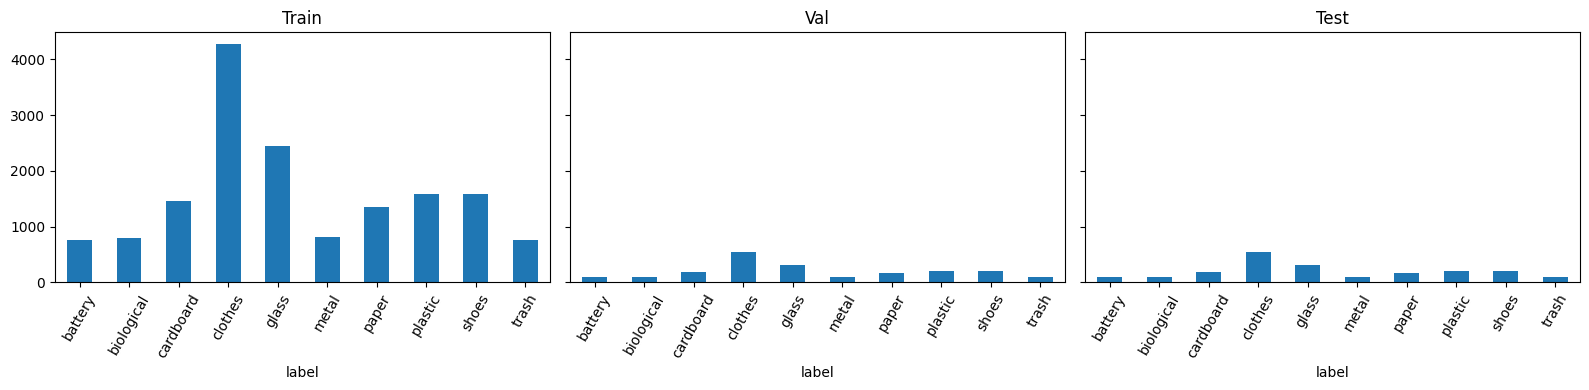

Saved splits to ./splits/ (include in paper supplementary).


In [4]:
# =========================
# Colab cell 3: Stratified 80/10/10 split
# =========================
from sklearn.model_selection import train_test_split
import os

SEED = 42
train_df, temp_df = train_test_split(df_all, test_size=0.20, stratify=df_all['label'], random_state=SEED)
val_df,   test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=SEED)

print("Train:", train_df.shape, " Val:", val_df.shape, " Test:", test_df.shape)

# Save CSVs (reproducibility)
os.makedirs("splits", exist_ok=True)
train_df.to_csv("splits/train.csv", index=False)
val_df.to_csv("splits/val.csv", index=False)
test_df.to_csv("splits/test.csv", index=False)

# Class distribution in each split
fig, axes = plt.subplots(1,3, figsize=(16,4), sharey=True)
for ax, df, title in zip(axes, [train_df,val_df,test_df], ["Train","Val","Test"]):
    counts = df['label'].value_counts().loc[classes]
    counts.plot(kind="bar", ax=ax, title=title)
    ax.tick_params(axis='x', rotation=60)
plt.tight_layout(); plt.show()

print("Saved splits to ./splits/ (include in paper supplementary).")


In [5]:
# =========================
# Colab cell 4: tf.data pipelines
# =========================
import tensorflow as tf
import numpy as np # Added import for numpy
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 224
BATCH_SIZE = 32

# Label mapping
class_to_index = {c:i for i,c in enumerate(classes)}
index_to_class = {i:c for c,i in class_to_index.items()}

def df_to_dataset(df, shuffle=True, augment=False, cache=False):
    paths  = df['filepath'].values
    labels = df['label'].map(class_to_index).astype(np.int32).values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(min(len(paths), 4000), seed=SEED, reshuffle_each_iteration=True)
    def _load(path, label):
        img_b = tf.io.read_file(path)
        img   = tf.io.decode_image(img_b, channels=3, expand_animations=False)   # force RGB
        img.set_shape([None, None, 3])
        img   = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method="bilinear")
        img   = tf.cast(img, tf.float32)  # keep 0..255; model preprocess will scale
        return img, label
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)

    # Augment (train only): safe, fast ops
    aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.08),
        tf.keras.layers.RandomZoom(0.10),
        tf.keras.layers.RandomContrast(0.10),
    ], name="augment")
    def _aug(x,y):
        # brightness jitter in [0..255]
        x = tf.image.random_brightness(x, max_delta=20.0)
        x = tf.clip_by_value(x, 0.0, 255.0)
        x = aug(x, training=True)
        return x, y
    if augment:
        ds = ds.map(_aug, num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    if cache: ds = ds.cache()
    ds = ds.prefetch(AUTOTUNE)
    try:
        ds = ds.apply(tf.data.experimental.ignore_errors())
    except: pass
    return ds

train_ds = df_to_dataset(train_df, shuffle=True,  augment=True,  cache=False)
val_ds   = df_to_dataset(val_df,   shuffle=False, augment=False, cache=False)
test_ds  = df_to_dataset(test_df,  shuffle=False, augment=False, cache=False)

for imgs, labs in train_ds.take(1):
    print("Sanity batch:", imgs.shape, labs.shape, imgs.dtype)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Sanity batch: (32, 224, 224, 3) (32,) <dtype: 'float16'>


In [6]:
# =========================
# Colab cell 5: Class weights
# =========================
from sklearn.utils.class_weight import compute_class_weight
y_train = train_df['label'].map(class_to_index).values
cw = compute_class_weight(class_weight='balanced',
                          classes=np.arange(len(classes)),
                          y=y_train)
CLASS_WEIGHTS = {i: float(w) for i,w in enumerate(cw)}
print("Class weights:", {index_to_class[i]: round(w,3) for i,w in CLASS_WEIGHTS.items()})


Class weights: {'battery': 2.095, 'biological': 1.985, 'cardboard': 1.084, 'clothes': 0.37, 'glass': 0.646, 'metal': 1.939, 'paper': 1.177, 'plastic': 0.997, 'shoes': 1.001, 'trash': 2.087}


In [7]:
# =========================
# Colab cell 6: Model build (ResNet101)
# =========================
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input as rn_preprocess
import numpy as np

def build_resnet101(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(classes), dropout=0.4):
    inputs = layers.Input(shape=input_shape, name="image")
    # ResNet preprocess expects 0..255 float inputs; it will BGR-shift & mean-center
    x = layers.Lambda(rn_preprocess, name="preprocess")(inputs)

    base = ResNet101(include_top=False, weights="imagenet", input_shape=input_shape)
    base.trainable = False

    x = base(x)  # keep BN frozen while base is frozen
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    # Force float32 on the last layer for mixed precision stability
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)

    model = models.Model(inputs, outputs, name="ResNet101_Garbage")
    # convenient handles for fine-tuning later
    model._base = base
    model._unfreeze_k = 50  # unfreeze the top ~50 layers during fine-tuning (tweak if needed)

    model.summary(line_length=110)
    trainable = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    nontrain  = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
    print(f"Trainable params: {trainable:,} | Non-trainable: {nontrain:,}")
    return model

model = build_resnet101()


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "ResNet101_Garbage"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                             │ (None, 224, 224, 3)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ preprocess (Lambda)                            │ (None, 224, 224, 3)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ resnet101 (Functional)                         │ (None, 7, 7, 2048)                  │          42,658,176 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ global_average_pooling2d                       │ (None, 2048)                        │                   0 │
│ (GlobalAveragePooling2D)                       │                                     │                     │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, 2048)                        │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dense (Dense)                                  │ (None, 10)                          │              20,490 │
└────────────────────────────────────────────────┴─────────────────────────────────────┴─────────────────────┘

 Total params: 42,678,666 (162.81 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 42,658,176 (162.73 MB)

Trainable params: 20,490 | Non-trainable: 42,658,176


In [8]:
# =========================
# Colab cell 7: Stage A training (head only)
# =========================
import time
class EpochTimer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None): self.times=[]
    def on_epoch_begin(self, epoch, logs=None): self._t=time.time()
    def on_epoch_end(self, epoch, logs=None): self.times.append(time.time()-self._t)

EPOCHS_STAGE1 = 10
timerA = EpochTimer()
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
cbA = [
    tf.keras.callbacks.ModelCheckpoint("resnet101_stage1.keras", monitor="val_loss", save_best_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    timerA
]
histA = model.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_STAGE1,
    class_weight=CLASS_WEIGHTS, callbacks=cbA, verbose=1
)


Epoch 1/10
    493/Unknown 445s 837ms/step - accuracy: 0.7134 - loss: 1.0101

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.26756, saving model to resnet101_stage1.keras
493/493 ━━━━━━━━━━━━━━━━━━━━ 476s 900ms/step - accuracy: 0.7136 - loss: 1.0093 - val_accuracy: 0.9168 - val_loss: 0.2676 - learning_rate: 0.0010
Epoch 2/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.8985 - loss: 0.3420
Epoch 2: val_loss improved from 0.26756 to 0.22273, saving model to resnet101_stage1.keras
493/493 ━━━━━━━━━━━━━━━━━━━━ 354s 717ms/step - accuracy: 0.8985 - loss: 0.3419 - val_accuracy: 0.9347 - val_loss: 0.2227 - learning_rate: 0.0010
Epoch 3/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9048 - loss: 0.3093
Epoch 3: val_loss improved from 0.22273 to 0.22078, saving model to resnet101_stage1.keras
493/493 ━━━━━━━━━━━━━━━━━━━━ 381s 773ms/step - accuracy: 0.9048 - loss: 0.3093 - val_accuracy: 0.9378 - val_loss: 0.2208 - learning_rate: 0.0010
Epoch 4/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9207 - loss: 0.2621
Epoch 4: val_loss did not impro

In [9]:
# =========================
# Colab cell 8: Stage B fine-tuning (top layers)
# =========================
# Unfreeze top-k layers of the base
k = getattr(model, "_unfreeze_k", 50)
model._base.trainable = True
for layer in model._base.layers[:-k]:
    layer.trainable = False
for layer in model._base.layers[-k:]:
    layer.trainable = True

EPOCHS_STAGE2 = 10
timerB = EpochTimer()
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
cbB = [
    tf.keras.callbacks.ModelCheckpoint("resnet101_finetuned.keras", monitor="val_loss", save_best_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    timerB
]
histB = model.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_STAGE2,
    class_weight=CLASS_WEIGHTS, callbacks=cbB, verbose=1
)

# Save final model
model.save("final_resnet101.keras")
print("Saved final_resnet101.keras")


Epoch 1/10
    493/Unknown 415s 738ms/step - accuracy: 0.9164 - loss: 0.2672
Epoch 1: val_loss improved from inf to 0.19971, saving model to resnet101_finetuned.keras
493/493 ━━━━━━━━━━━━━━━━━━━━ 448s 805ms/step - accuracy: 0.9164 - loss: 0.2671 - val_accuracy: 0.9455 - val_loss: 0.1997 - learning_rate: 1.0000e-05
Epoch 2/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.9379 - loss: 0.1812
Epoch 2: val_loss improved from 0.19971 to 0.18532, saving model to resnet101_finetuned.keras
493/493 ━━━━━━━━━━━━━━━━━━━━ 368s 747ms/step - accuracy: 0.9379 - loss: 0.1811 - val_accuracy: 0.9481 - val_loss: 0.1853 - learning_rate: 1.0000e-05
Epoch 3/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9533 - loss: 0.1365
Epoch 3: val_loss improved from 0.18532 to 0.17167, saving model to resnet101_finetuned.keras
493/493 ━━━━━━━━━━━━━━━━━━━━ 367s 744ms/step - accuracy: 0.9533 - loss: 0.1365 - val_accuracy: 0.9527 - val_loss: 0.1717 - learning_rate: 1.0000e-05
Epoch 4/10
493/493 ━━━


Test Accuracy: 0.9651  |  Macro-Precision: 0.9583  Macro-Recall: 0.9570  Macro-F1: 0.9574

              precision    recall  f1-score   support

     battery     0.9891    0.9579    0.9733        95
  biological     1.0000    0.9600    0.9796       100
   cardboard     0.9721    0.9560    0.9640       182
     clothes     0.9906    0.9906    0.9906       534
       glass     0.9521    0.9739    0.9628       306
       metal     0.9216    0.9216    0.9216       102
       paper     0.9471    0.9583    0.9527       168
     plastic     0.9485    0.9246    0.9364       199
       shoes     0.9796    0.9697    0.9746       198
       trash     0.8824    0.9574    0.9184        94

    accuracy                         0.9651      1978
   macro avg     0.9583    0.9570    0.9574      1978
weighted avg     0.9656    0.9651    0.9652      1978



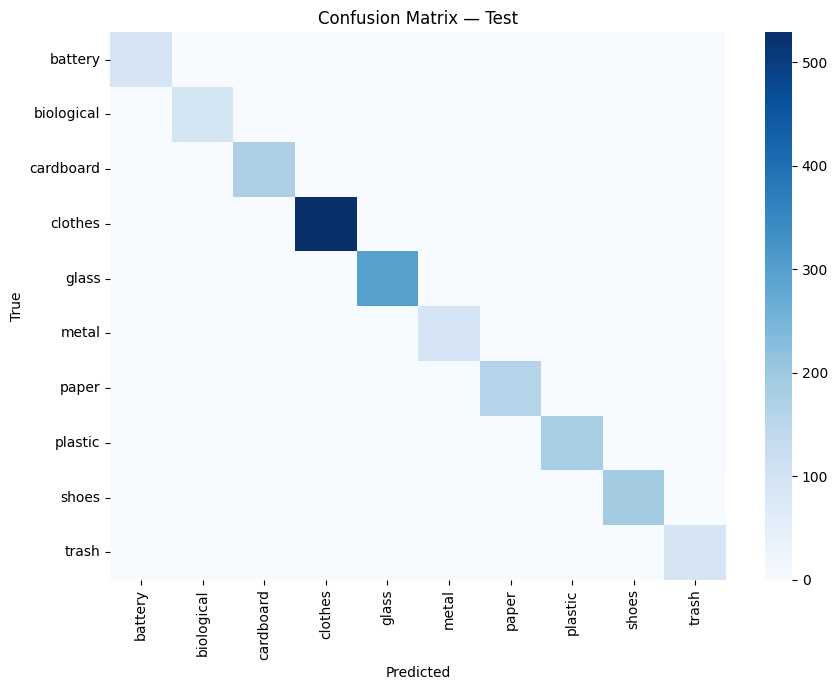

Avg time/epoch (approx): 382.30s
Model size: 423.07 MB


In [10]:
# =========================
# Colab cell 9: Evaluation
# =========================
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Inference on test
y_true, y_pred = [], []
for x_batch, y_batch in test_ds:
    preds = model.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1).tolist())
    y_true.extend(y_batch.numpy().tolist())

y_true = np.array(y_true); y_pred = np.array(y_pred)
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)

print(f"\nTest Accuracy: {acc:.4f}  |  Macro-Precision: {prec:.4f}  Macro-Recall: {rec:.4f}  Macro-F1: {f1:.4f}\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# Confusion matrix (normalized for readability)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, cmap="Blues", xticklabels=classes, yticklabels=classes, cbar=True)
plt.title("Confusion Matrix — Test"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# Per-class metrics CSV (for the paper)
p_i, r_i, f1_i, sup_i = precision_recall_fscore_support(y_true, y_pred, labels=range(len(classes)), zero_division=0)
df_metrics = pd.DataFrame({"class": classes, "precision": p_i, "recall": r_i, "f1": f1_i, "support": sup_i})
df_metrics.to_csv("per_class_metrics.csv", index=False); df_metrics.head()

# Time per epoch & model size
def path_size_mb(path):
    import os
    if os.path.isfile(path): return os.path.getsize(path)/(1024*1024)
    total=0
    for r,_,fs in os.walk(path):
        for f in fs: total += os.path.getsize(os.path.join(r,f))
    return total/(1024*1024)

avg_time_epoch = float(np.mean(timerA.times + timerB.times)) if (timerA.times or timerB.times) else np.nan
print(f"Avg time/epoch (approx): {avg_time_epoch:.2f}s")
print("Model size:", f"{path_size_mb('final_resnet101.keras'):.2f} MB")

